# Imports:

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

["'pwd' is not recognized as an internal or external command,",
 'operable program or batch file.']

# Functions:

Mode: 'binary', '3-class', '4-class', '5-class', '6-class'

In [3]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [4]:
def epoch_label_extractor(data, events, epoch_length, num_channels, sampling_freq):
    
    data = data.to_data_frame()
    events = events[0]
    third_column = events[:, 2]
    mask = np.isin(third_column, [7, 8, 9, 10])
    MI_events = events[mask]
    
    number_of_epochs = MI_events.shape[0]
    labels = np.zeros((number_of_epochs,1)).astype(int)
    epochs = np.zeros((number_of_epochs, num_channels, epoch_length * sampling_freq))
    index = 0
    for index in range(number_of_epochs):
        start = int(MI_events[index, 0])
        end = int(MI_events[index, 0]) + epoch_length * sampling_freq
        all_channels = data.iloc[start:end]
        epochs[index,:,:] = all_channels[all_channels.columns[1: num_channels+1]].T
        
        # Because it is numbered form 7 to 10 !!!
        labels[index] = MI_events[index, 2] - 7

            
    return epochs, labels

In [5]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [6]:
def calc_csp(x_train, y_train, x_test, number_of_components=10):
    
        csp = CSP(number_of_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [7]:
def feature_extraction_4(dataset, labels, test_data, sampling_freq):

    # Why number of bands were set to 24??
    
    low_cutoff = 0
    number_of_bands = 8
    for b in range(number_of_bands):
        data = dataset.copy()
        data_test = test_data.copy()
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, labels[:, 0], filtered_data_test)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 4
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

# Device (GPU\CPU\MPS)

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Data reading:

In [9]:
raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"

try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/BCI_IV_2a/gdf"
            

except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"
    
    

train_data_epochs = []
train_data_labels = []
test_data_epochs = []
test_data_labels = []
for participant_id in range(1, 10):
    participant_E = f"A0{participant_id}E"
    participant_T = f"A0{participant_id}T"

    file_path_E = f"{raw_data_path}/{participant_E}.gdf"
    file_path_T = f"{raw_data_path}/{participant_T}.gdf"

    raw_train = mne.io.read_raw_gdf(file_path_T, preload=True)
    raw_test = mne.io.read_raw_gdf(file_path_E, preload=True)


    train_events = mne.events_from_annotations(raw_train)
    test_events = mne.events_from_annotations(raw_test)

    train_epochs, train_labels = epoch_label_extractor(raw_train, train_events, epoch_length = 4, num_channels = 22, sampling_freq = 250)
    #test_epochs, test_labels = epoch_label_extractor(raw_test, test_events, epoch_length = 4, num_channels = 22, sampling_freq = 250)

    train_data_epochs.append(train_epochs)
    #test_data_epochs.append(test_epochs)
    train_data_labels.append(train_labels)
    #test_data_labels.append(test_labels)

Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


In [10]:
for i in range(9):
    print("Subject {} train epochs:    ".format(i+1), train_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), train_data_labels[i].shape)
    #print("Subject {} test epochs:     ".format(i+1), test_data_epochs[i].shape, "    Subject {} test labels:     ".format(i+1), test_data_labels[i].shape)

Subject 1 train epochs:     (288, 22, 1000)     Subject 1 train labels:     (288, 1)
Subject 2 train epochs:     (288, 22, 1000)     Subject 2 train labels:     (288, 1)
Subject 3 train epochs:     (288, 22, 1000)     Subject 3 train labels:     (288, 1)
Subject 4 train epochs:     (144, 22, 1000)     Subject 4 train labels:     (144, 1)
Subject 5 train epochs:     (288, 22, 1000)     Subject 5 train labels:     (288, 1)
Subject 6 train epochs:     (288, 22, 1000)     Subject 6 train labels:     (288, 1)
Subject 7 train epochs:     (288, 22, 1000)     Subject 7 train labels:     (288, 1)
Subject 8 train epochs:     (288, 22, 1000)     Subject 8 train labels:     (288, 1)
Subject 9 train epochs:     (288, 22, 1000)     Subject 9 train labels:     (288, 1)


In [11]:
# all_data_epochs = np.zeros(len(train_data_epochs)).tolist()
# all_data_labels = np.zeros(len(train_data_epochs)).tolist()

# for i in range(len(train_data_epochs)):
#     all_data_epochs[i] = np.concatenate((train_data_epochs[i], test_data_epochs[i]), axis=0)
#     all_data_labels[i] = np.concatenate((train_data_labels[i], test_data_labels[i]), axis=0)


all_data_epochs = train_data_epochs
all_data_labels = train_data_labels

In [12]:
# # Checking if the concatenation does not have a problem!

# print("Specific element in train and test sets:      ", train_data_epochs[i][10, 10, 10], test_data_epochs[i][100, 13, 14])
# print("The same element in all data set combined:    ", all_data_epochs[i][10, 10, 10], all_data_epochs[i][388, 13, 14])
# print("\n\n")
# print("Checking the labels in train and test:        ", train_data_labels[i][10], test_data_labels[i][100])
# print("The same element in all data set combined:    ", all_data_labels[i][10], all_data_labels[i][388])

In [13]:
all_data_labels[0][:, 0]

array([3, 2, 1, 0, 0, 1, 2, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 2, 0, 1, 3,
       3, 2, 0, 3, 3, 1, 3, 3, 1, 0, 1, 2, 2, 2, 3, 2, 0, 3, 1, 2, 1, 2,
       3, 1, 2, 0, 0, 0, 3, 1, 0, 2, 0, 2, 1, 3, 0, 2, 2, 0, 2, 1, 3, 3,
       3, 2, 0, 3, 1, 3, 1, 0, 2, 1, 0, 2, 2, 0, 2, 3, 3, 1, 0, 1, 3, 1,
       3, 2, 1, 1, 1, 2, 3, 0, 1, 3, 0, 2, 2, 3, 0, 0, 2, 1, 3, 3, 3, 1,
       0, 2, 1, 3, 0, 3, 2, 1, 3, 3, 0, 1, 1, 2, 3, 1, 0, 0, 3, 1, 0, 2,
       1, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 3, 0, 3,
       0, 0, 1, 3, 2, 1, 3, 2, 3, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 3, 0, 3,
       0, 2, 0, 3, 0, 2, 0, 1, 2, 2, 3, 0, 1, 3, 1, 2, 2, 0, 3, 1, 3, 0,
       0, 2, 2, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 0, 1, 2,
       1, 0, 3, 0, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 2, 2, 3, 2, 0, 2, 0, 3,
       1, 3, 3, 2, 3, 3, 2, 1, 3, 2, 0, 1, 1, 1, 2, 1, 3, 2, 3, 1, 2, 0,
       3, 0, 2, 3, 0, 2, 0, 1, 1, 0, 3, 0, 3, 2, 2, 0, 2, 1, 1, 0, 2, 0,
       1, 0])

In [14]:
for i in range(len(all_data_epochs)):
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (288, 22, 1000)     All label shape (sub 0):      (288, 1)
All data epoch shape (sub 1):     (288, 22, 1000)     All label shape (sub 1):      (288, 1)
All data epoch shape (sub 2):     (288, 22, 1000)     All label shape (sub 2):      (288, 1)
All data epoch shape (sub 3):     (144, 22, 1000)     All label shape (sub 3):      (144, 1)
All data epoch shape (sub 4):     (288, 22, 1000)     All label shape (sub 4):      (288, 1)
All data epoch shape (sub 5):     (288, 22, 1000)     All label shape (sub 5):      (288, 1)
All data epoch shape (sub 6):     (288, 22, 1000)     All label shape (sub 6):      (288, 1)
All data epoch shape (sub 7):     (288, 22, 1000)     All label shape (sub 7):      (288, 1)
All data epoch shape (sub 8):     (288, 22, 1000)     All label shape (sub 8):      (288, 1)


In [15]:
all_data_labels[1][:10]

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [2],
       [1],
       [3]])

# Encoding

In [16]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [17]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 9
labels Length: 9



Participant 16 - Epochs[0] shape: (144, 1)
Participant 16 - labels[0] shape: (144, 4)



Participant 16 - labels[0]:
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


# Within Subject:

In [ ]:
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []





for j in range(num_subjects):
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        print("      Train labels' shape:                               ", train_labels.shape)
        print("      Test labels' shape:                                ", test_labels.shape)
        print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

        print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)

        print('\n\n')


        # Create the EEGNet model
        model = XGBClassifier()




        #     # Normalizing the features
        #     mean = train_epochs.mean(axis=(0, 2), keepdims=True)
        #     std = train_epochs.std(axis=(0, 2), keepdims=True)

        #     print(mean.shape)
        #     print(std.shape)

        #     norm_train_epochs = (train_epochs - mean) / std
        #     norm_test_epochs = (test_epochs - mean) / std
        #     # Commented the normalization part since it reduces the rank of data and rasing errors with 
        #     # CSP filter bank

        train_features, test_features = feature_extraction_4(train_epochs, no_encoded_train_labels, test_epochs, sampling_freq = 250)
        print("Train features shape:", train_features.shape)
        print("Test features shape:", test_features.shape)

        # Train the model
        model.fit(train_features, no_encoded_train_labels[:, 0])

        # Test the model
        y_pred = model.predict(test_features)
        
        tests_pred.append(y_pred)
        tests_true.append(no_encoded_test_labels[:, 0])
    
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


In [19]:
print(len(all_tests_pred))

9


In [20]:
print(np.concatenate(all_tests_pred[4]).shape)

(288,)


In [21]:
for i in range(len(all_tests_true)):
   print(all_tests_true[i])


[array([0, 2, 1, 3, 2, 0, 1, 0, 0, 1, 0, 1, 2, 3, 3, 2, 3, 3, 1, 1, 1, 2,
       3, 2, 0, 3, 3, 0, 1, 0, 1, 2, 1, 0, 2, 2, 2, 3, 0, 1, 3, 1, 3, 1,
       2, 3, 0, 1, 3, 2, 1, 3, 0, 2, 2, 0, 3, 0]), array([0, 0, 1, 3, 2, 1, 2, 3, 0, 3, 0, 2, 3, 3, 2, 1, 3, 1, 3, 0, 1, 3,
       1, 1, 2, 3, 0, 1, 3, 1, 3, 0, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 2, 2,
       3, 3, 2, 1, 1, 2, 0, 3, 0, 3, 2, 2, 0, 1]), array([2, 3, 0, 2, 3, 2, 2, 1, 0, 1, 0, 2, 0, 2, 2, 3, 0, 1, 3, 0, 1, 1,
       2, 1, 0, 0, 3, 2, 0, 2, 1, 3, 2, 1, 1, 3, 3, 2, 0, 3, 3, 2, 0, 3,
       2, 1, 3, 1, 3, 0, 0, 1, 1, 3, 0, 1, 2, 0]), array([1, 1, 0, 1, 3, 3, 3, 2, 2, 3, 2, 2, 0, 2, 3, 0, 1, 0, 2, 0, 1, 1,
       0, 2, 2, 0, 0, 2, 2, 1, 2, 1, 3, 0, 3, 1, 1, 2, 3, 3, 0, 3, 1, 3,
       1, 0, 0, 1, 3, 0, 3, 3, 1, 2, 2, 2, 0]), array([3, 0, 2, 0, 1, 0, 3, 3, 1, 1, 2, 0, 3, 1, 1, 2, 2, 0, 3, 1, 3, 0,
       2, 3, 3, 1, 3, 3, 0, 3, 2, 0, 0, 1, 2, 3, 0, 1, 2, 0, 2, 1, 3, 1,
       0, 1, 0, 2, 2, 1, 3, 2, 1, 2, 0, 2, 1])]
[array([1, 0, 1, 3, 

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrices = []
for i in range(len(all_tests_pred)):
    if i == 3:
        continue
    y_true = np.concatenate(all_tests_true[i])
    y_pred = np.concatenate(all_tests_pred[i])
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [23]:
print(confusion_matrices[1])

[[35 24  4  9]
 [21 34  6 11]
 [ 1  2 67  2]
 [16  4  6 46]]


In [24]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
acc = np.sum(summation / 576 * np.eye(4, 4)).sum() / 4


C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [25]:
print("The within subject scenario:")
print("Algorithm: XGBClassifier")
print("Accuracy: ", acc)

summation / 576

The within subject scenario:
Algorithm: XGBClassifier
Accuracy:  0.74609375


,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),0.737847,0.112847,0.055556,0.093750
Right (True),0.112847,0.739583,0.071181,0.076389
Feet (True),0.064236,0.067708,0.732639,0.135417
Tongue (True),0.076389,0.048611,0.100694,0.774306


In [26]:
summation.sum(axis=1)

Left (True)      576
Right (True)     576
Feet (True)      576
Tongue (True)    576
dtype: int64

In [27]:
np.sum(summation / 576 * np.eye(4, 4)).sum() / 4

C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.74609375

# Cross-subjects (WO hyperparameter tuning):

In [18]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []




kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
#     print("Outer Loop {}".format(i+1), "\n")
#     print("      Train epochs' shape:                               ", train_epochs.shape)

#     print("      Test epochs' shape:                                ", test_epochs.shape)
#     print("      Test labels' shape:                                ", test_labels.shape)
#     print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

#     print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
#     print("      Train index:                                       ", train_ids_for_save)

#     print("      Test index:                                        ", test_ids_for_save)
#     print('\n\n')
    
    
    # Create the EEGNet model
    model = XGBClassifier()
    
    
    original_stdout = sys.stdout
    sys.stdout = open('temp_stdout{}.txt'.format(i+10000), 'w')  # Redirect output to a temporary file
    train_features, test_features = feature_extraction_4(train_epochs, no_encoded_train_labels, test_epochs, sampling_freq = 250)
    sys.stdout.close()
    sys.stdout = original_stdout
    
    
    print("Train features shape:", train_features.shape)
    print("Test features shape:", test_features.shape)
    
    # Train the model
    model.fit(train_features, no_encoded_train_labels)
    
    # Test the model
    y_pred = model.predict(test_features)
    
    
    all_tests_pred.append(y_pred)
    all_tests_true.append(no_encoded_test_labels)
    with open("all_tests_pred_{}.pickle".format(i), "wb") as f:
        pickle.dump(all_tests_pred, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
        
    with open("all_tests_true_{}.pickle".format(i), "wb") as f:
        pickle.dump(all_tests_true, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
        
    with open("indexes.pickle", "wb") as f:
        pickle.dump(test_index, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    
    with open("train_features_{}.pickle".format(i), "wb") as f:
        pickle.dump(train_features, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
        
    with open("test_features_{}.pickle".format(i), "wb") as f:
        pickle.dump(test_features, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    print("The {}th run out of 9 is done!".format(i))

Train features shape: (2160, 80)
Test features shape: (288, 80)
The 0th run out of 9 is done!
Train features shape: (2160, 80)
Test features shape: (288, 80)
The 1th run out of 9 is done!
Train features shape: (2160, 80)
Test features shape: (288, 80)
The 2th run out of 9 is done!
Train features shape: (2160, 80)
Test features shape: (288, 80)
The 3th run out of 9 is done!
Train features shape: (2304, 80)
Test features shape: (144, 80)
The 4th run out of 9 is done!
Train features shape: (2160, 80)
Test features shape: (288, 80)
The 5th run out of 9 is done!
Train features shape: (2160, 80)
Test features shape: (288, 80)
The 6th run out of 9 is done!
Train features shape: (2160, 80)
Test features shape: (288, 80)
The 7th run out of 9 is done!
Train features shape: (2160, 80)
Test features shape: (288, 80)
The 8th run out of 9 is done!


In [19]:
len(all_tests_pred[2])

288

In [20]:
confusion_matrices = []
for i in range(len(all_tests_pred)):
    if i == 3:
        continue
    y_true = all_tests_true[i]
    y_pred = all_tests_pred[i]
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [21]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
acc = np.sum(summation / 576 * np.eye(4, 4)).sum() / 4


C:\ProgramData\Anaconda3\envs\BCI_2\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [22]:
summation.sum(axis=1)

Left (True)      576
Right (True)     576
Feet (True)      504
Tongue (True)    504
dtype: int64

In [38]:
import sys
print("Hello, worimport sys")
sys.stdout
sys.stdout = sys.__stdout__
sys.stdout

<_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>

In [41]:
acc

0.3120659722222222

In [23]:
print("The cross-subject scenario:")
print("Algorithm: XGBClassifier")
print("Accuracy: ", acc)

summation / 576

The cross-subject scenario:
Algorithm: XGBClassifier
Accuracy:  0.3125


,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),0.319444,0.296875,0.164931,0.218750
Right (True),0.184028,0.505208,0.102431,0.208333
Feet (True),0.190972,0.288194,0.147569,0.248264
Tongue (True),0.223958,0.267361,0.105903,0.277778


In [19]:
summation / 780 * 100

,L (Pred),LS (Pred),S (Pred),RS (True),R (True),Rest (Pred)
L (True),36.410256,9.487179,12.307692,22.692308,8.846154,10.256410
LS (True),9.615385,36.538462,10.128205,9.615385,27.435897,6.666667
S (True),10.512821,11.538462,32.948718,8.846154,10.769231,25.384615
RS (True),33.461538,10.384615,9.615385,27.435897,10.256410,8.846154
R (True),11.153846,33.461538,10.384615,12.564103,25.512821,6.923077
Rest (True),12.179487,10.641026,30.000000,10.128205,10.769231,26.282051


In [ ]:
import pickle
with open("3class_all_tests_pred", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("3class_all_tests_true", "wb") as fp:
    pickle.dump(all_tests_true, fp)

    
print(all_tests_pred[1][1].shape)
print(all_tests_pred[12][1].shape)

In [ ]:
with open("3class_all_tests_pred", "rb") as fp:
    rand_var = pickle.load(fp)

    
with open("3class_all_tests_true", "rb") as fp:
    rand_var2 = pickle.load(fp)
print(rand_var[12][1].shape)
print(rand_var2[12][1].shape)

In [ ]:
all_tests_pred[1][2].shape

In [ ]:
np.argmax(all_tests_true[12][1], axis=1)+1

In [ ]:
a = np.array([[1, 2, 3], [4, 50, 6]])
np.sum(a, axis=1)

In [ ]:
y_true

In [ ]:
confusion_matrices_ap = []
y_pred_prob = []
for i in range(len(all_tests_pred)):
    y_pred = np.zeros(all_tests_true[i][0].shape)
    for j in range(len(all_tests_pred[1])):
        y_pred += all_tests_pred[i][j]
    y_pred_prob.append(y_pred/6)
    confusion_matrices_ap.append(confusion_matrix(np.argmax(all_tests_true[i][0], axis=1)+1, np.argmax(y_pred_prob[i], axis=1)+1))

In [ ]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)', 'class 3 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)', 'class 3 (Pred)'])
summation

In [ ]:
total_samples = summation.values.sum()
correct_predictions = summation.values.trace()
overall_accuracy = correct_predictions / total_samples

# Calculate accuracy for each class
class_accuracy = summation.values.diagonal() / summation.sum(axis=1)

# Print results
print(f"Overall Accuracy: {overall_accuracy:.2%}")

for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for Class {i + 1}: {acc:.2%}")

In [ ]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


In [ ]:
summation / (13 * 40) * 100

In [ ]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

,class 1 (Pred),class 2 (Pred)
class 1 (True),358,162
class 2 (True),202,315


In [31]:
summation / 520

,class 1 (Pred),class 2 (Pred)
class 1 (True),0.688462,0.311538
class 2 (True),0.388462,0.605769


In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63



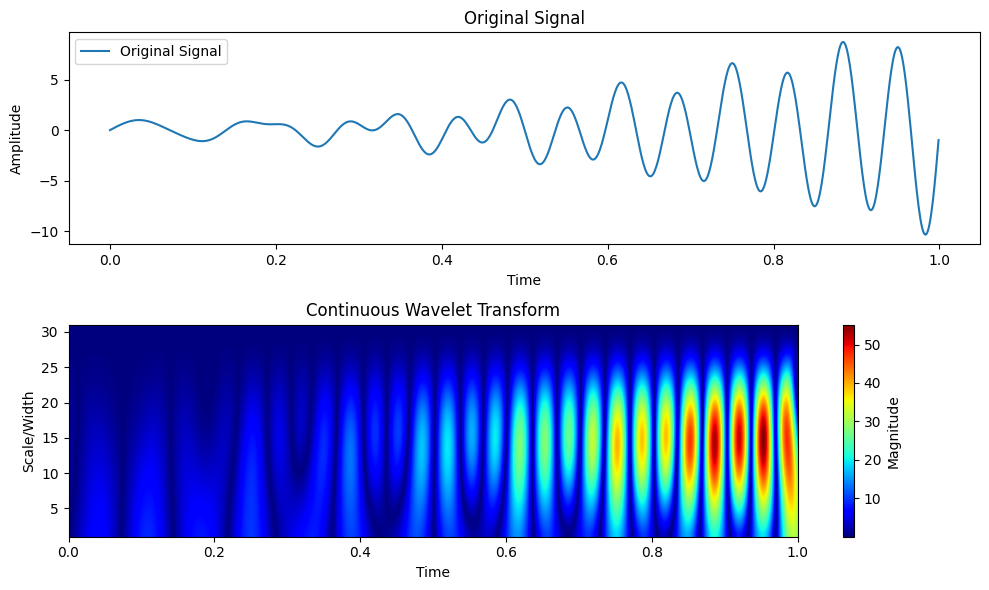

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cwt, ricker

# Generate a sample signal
t = np.linspace(0, 1, 1000, endpoint=False)  # Time vector
signal = np.sin(2 * np.pi * 7 * t) + 10 * t**2 * np.sin(2 * np.pi * 15 * t)

# Define the wavelet parameters
widths = np.arange(1, 31)  # Range of widths for the wavelet
wavelet = ricker  # Ricker wavelet is commonly used

# Calculate the CWT
cwt_result = cwt(signal, wavelet, widths)

# Plot the original signal and its CWT
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.imshow(np.abs(cwt_result), aspect='auto', extent=[0, 1, 1, 31], cmap='jet', interpolation='bilinear')
plt.title('Continuous Wavelet Transform')
plt.xlabel('Time')
plt.ylabel('Scale/Width')
plt.colorbar(label='Magnitude')

plt.tight_layout()
plt.show()


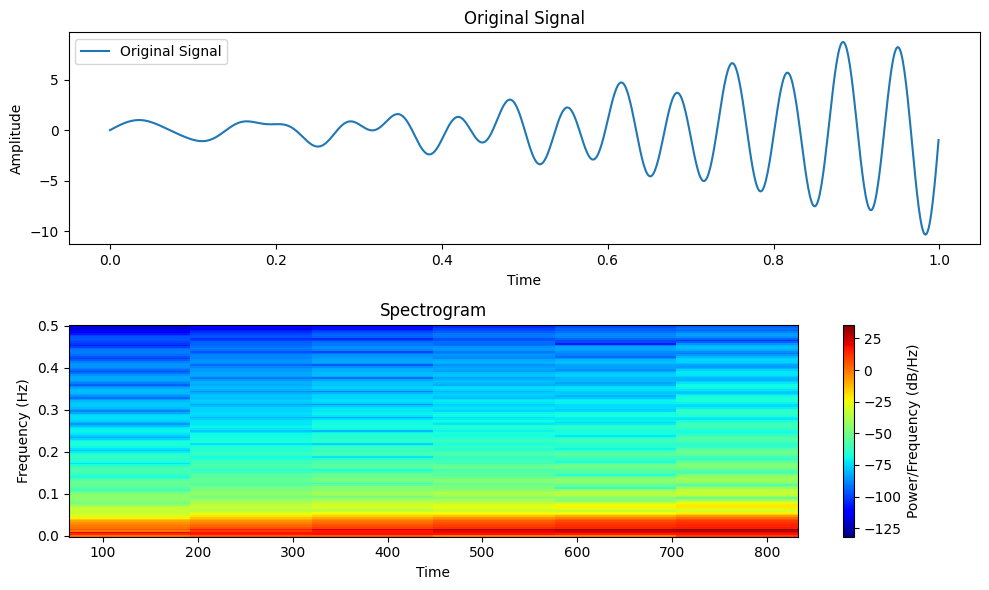

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Generate a sample signal
t = np.linspace(0, 1, 1000, endpoint=False)  # Time vector
signal = np.sin(2 * np.pi * 7 * t) + 10*t**2 * np.sin(2 * np.pi * 15 * t)

# Calculate the STFT
frequencies, times, spectrogram_result = spectrogram(signal, fs=1.0, nperseg=256, noverlap=128)

# Plot the original signal and its spectrogram
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram_result), shading='auto', cmap='jet')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()
